# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [2]:
churn_data = pd.read_csv('C:\скил\DST-156\IDE_NEW\ML-3. Обучение с учителем классификация/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

In [3]:
# Ваш код здесь
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Сразу избавимся от заведомо неинформативных признаков: номер строки, идентификатор пользователя и имя клиента.

In [4]:
churn_data = churn_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Проверим, что в наших данных нет пропусков:

In [5]:
churn_data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [6]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

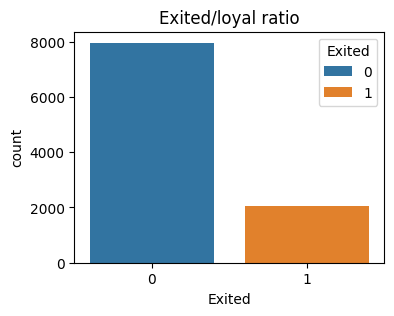

In [7]:
fig, ax = plt.subplots(figsize = (4, 3))
sns.countplot(
    data=churn_data,
    x='Exited',
    hue='Exited',
    ax=ax
)
ax.set_title('Exited/loyal ratio');

Видно, что ушедших клиентов почти в 4 раза меньше, значит классы несбалансированы.

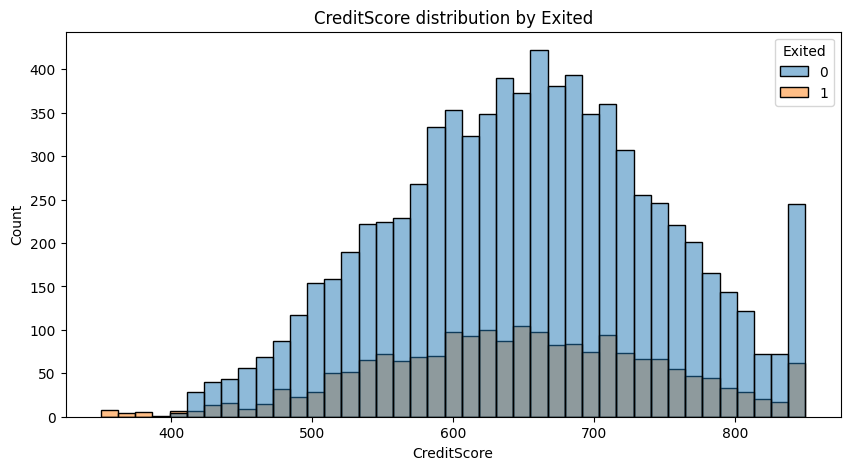

In [8]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(
    data=churn_data,
    x='CreditScore',
    hue=churn_data['Exited'],
    ax=ax
)
ax.set_title('CreditScore distribution by Exited');

Распределения кредитного рейтинга отличаются не сильно, разве что для ушедших чуть больше случаев с совсем низким рейтингом.

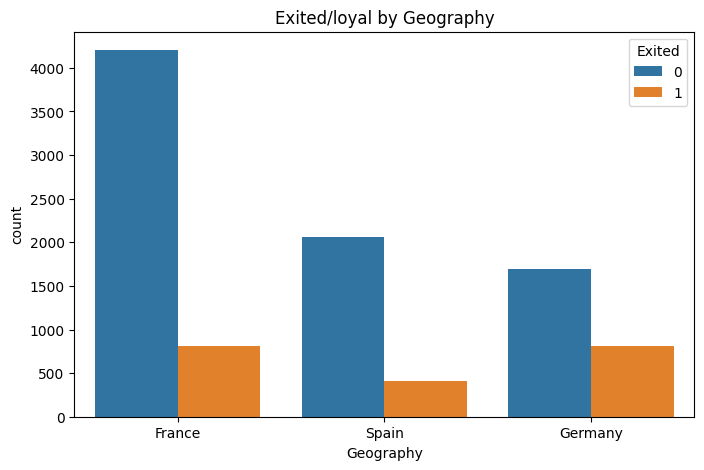

In [9]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.countplot(
    data=churn_data,
    x='Geography',
    hue='Exited',
    ax=ax
)
ax.set_title('Exited/loyal by Geography');

Доля ушедших больше всего в Германии, но даже там соотношение около 1/2.

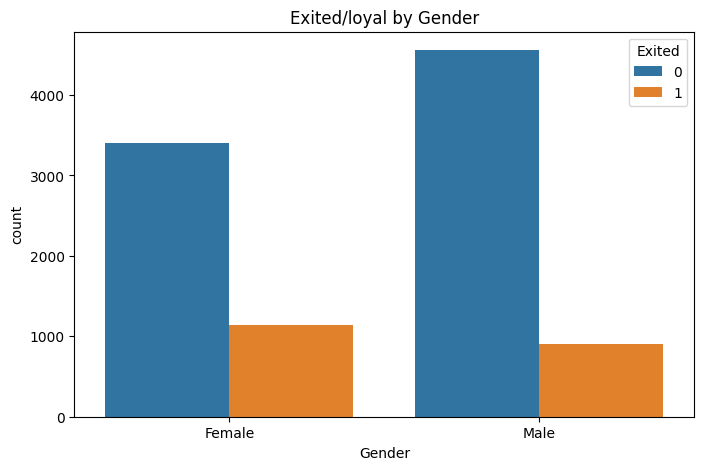

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.countplot(
    data=churn_data,
    x='Gender',
    hue='Exited',
    ax=ax
)
ax.set_title('Exited/loyal by Gender');

Среди женщин доля ушедших выше.

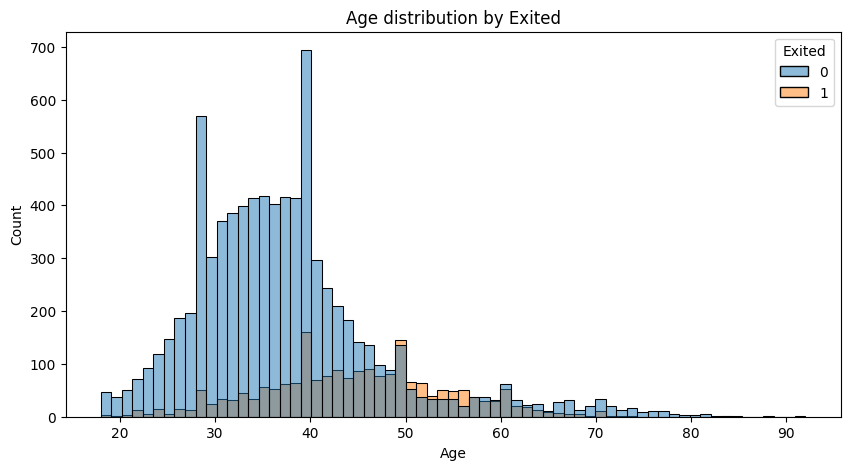

In [11]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(
    data=churn_data,
    x='Age',
    hue=churn_data['Exited'],
    ax=ax
)
ax.set_title('Age distribution by Exited');

Распределение ушедших смещено по возрасту вправо относительно лояльных, чаще всего уходят клиенты около 40-50 лет.

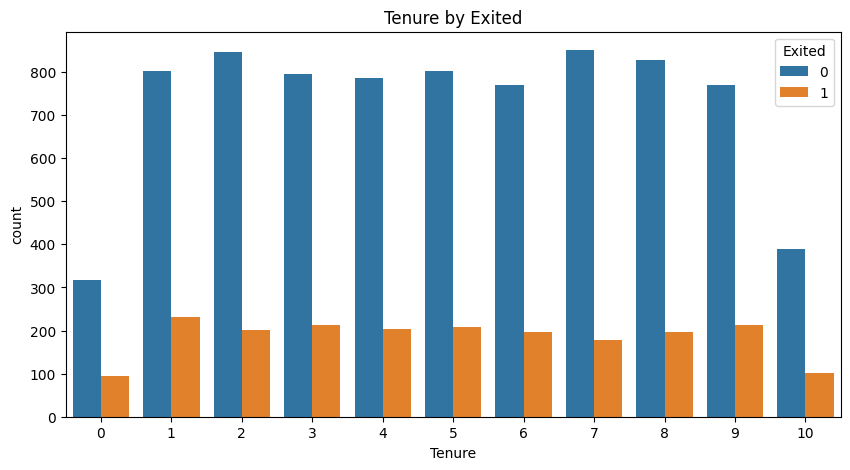

In [12]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot(
    data=churn_data,
    x='Tenure',
    hue=churn_data['Exited'],
    ax=ax
)
ax.set_title('Tenure by Exited');

Судя по всему, доля ушедших от времени, которое клиент пользуется банком, зависит не сильно.

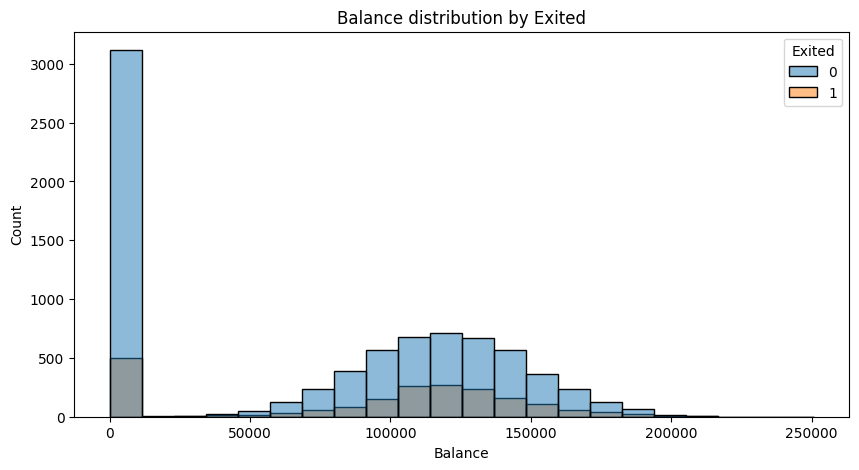

In [13]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(
    data=churn_data,
    x='Balance',
    hue=churn_data['Exited'],
    ax=ax
)
ax.set_title('Balance distribution by Exited');

Распределения также схожи. Только при нулевом балансе доля лояльных заметно больше.

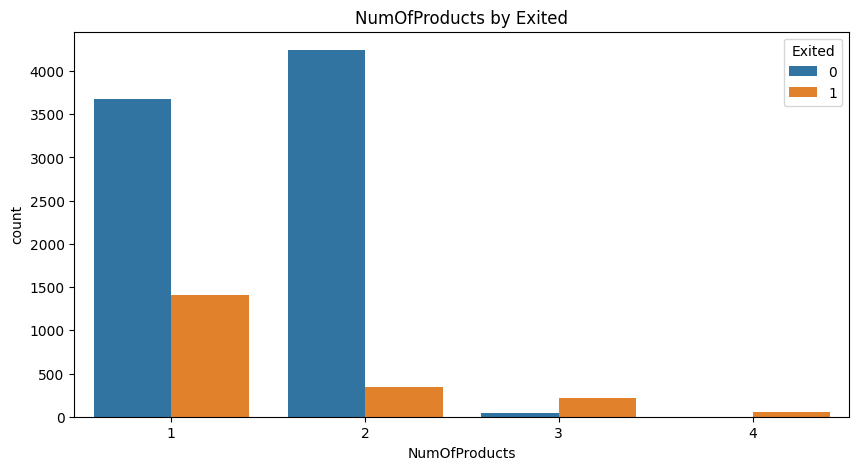

In [14]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot(
    data=churn_data,
    x='NumOfProducts',
    hue=churn_data['Exited'],
    ax=ax
)
ax.set_title('NumOfProducts by Exited');

Доля ушедших сначала падает, потом растёт.

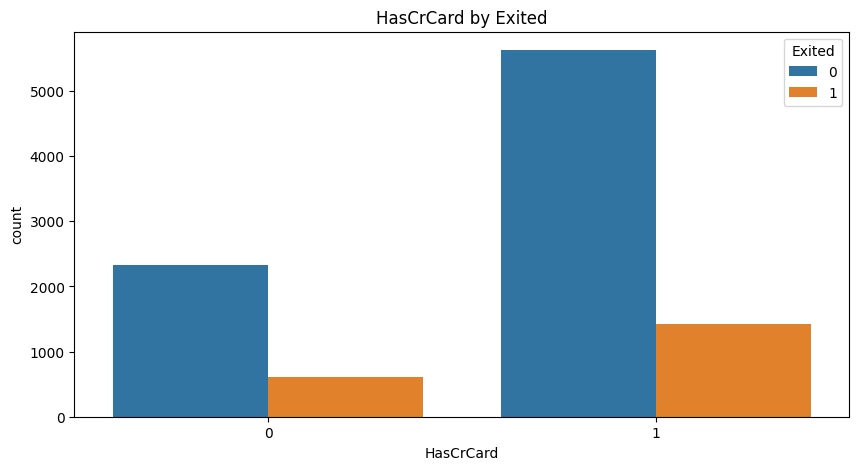

In [15]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot(
    data=churn_data,
    x='HasCrCard',
    hue=churn_data['Exited'],
    ax=ax
)
ax.set_title('HasCrCard by Exited');

Количество клиентов с кредитной картой выше, но доля ушедших среди них немного меньше.

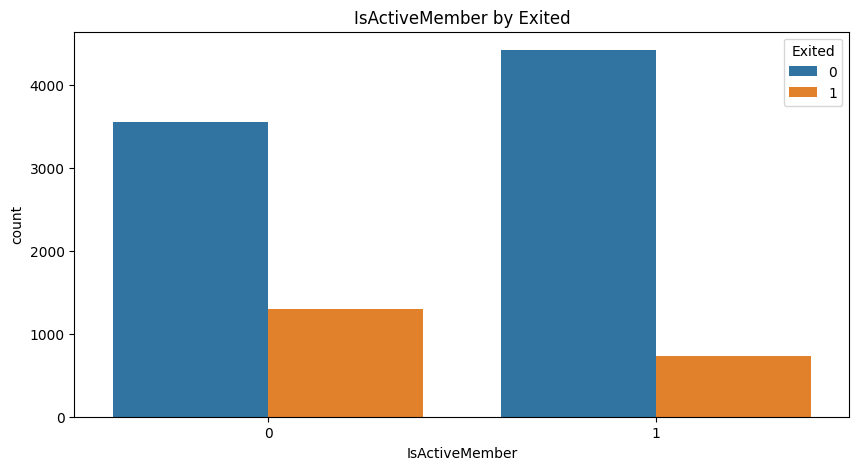

In [16]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot(
    data=churn_data,
    x='IsActiveMember',
    hue=churn_data['Exited'],
    ax=ax
)
ax.set_title('IsActiveMember by Exited');

Доля ушедших среди активных клиентов ниже.

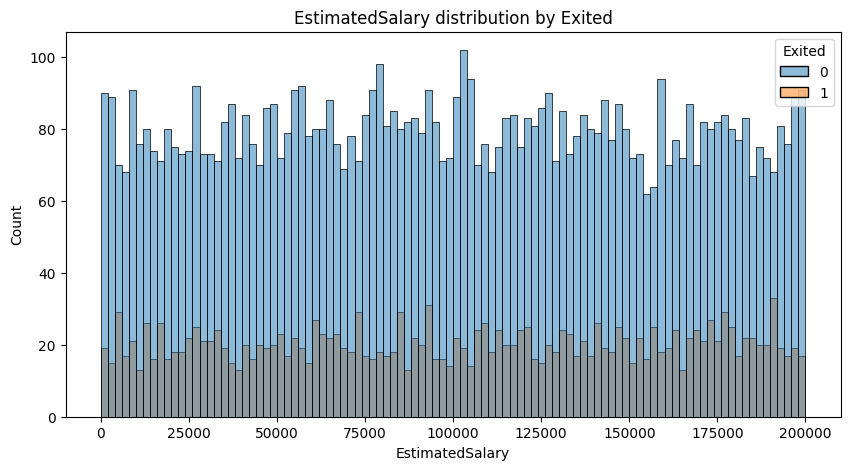

In [17]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.histplot(
    data=churn_data,
    bins=100,
    x='EstimatedSalary',
    hue=churn_data['Exited'],
    ax=ax
)
ax.set_title('EstimatedSalary distribution by Exited');

Решение клиента уходить или оставаться практически не зависит от предполагаемой зарплаты. По крайней мере зависимость не прослеживается.

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [18]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 11)

Можно сразу избавиться от признака Geography т.к. работаем дальше только по Германии

In [19]:
churn_data = churn_data.drop(['Geography'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [20]:
churn_data.shape

(2509, 10)

Проверим, что в наших данных нет пропусков:

In [21]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [22]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [23]:
# Ваш код здесь
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']#отношение баланса на счетах к заработной плате клиента
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])#отношение времени пользования услугами банка к возрасту клиента
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])#отношение кредитного рейтинга к возрасту клиента
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)# перекодируем оставшиеся текстовые категориальные признаки в числовые бинарные столбцы
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [24]:
churn_data.describe()# Выводим основные статистическе характеристики числовых полученных признаков

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,0.524512,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487
std,98.168937,0.499498,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558
min,350.000000,0.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676
25%,584.000000,0.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275
50%,651.000000,1.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143
75%,722.000000,1.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941
max,850.000000,1.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [25]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [26]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [28]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [29]:
# Ваш код здесь
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Укажите название метрики и обоснования своего выбора здесь

Ответ: Выбираем $F_1$ взвешенное среднее гармоническое между precision и recall, т.к. классы несбалансированы, а необходимо минимизировать ошибки 1 и 2 рода. $F_1$-мера повзоляет сбалансировать Precison и Recall, т.к. в числителе стоит их произведение. В следствие этого при стремлении одной из метрик к 0, $F_1$-мера также будет стремиться к 0, а при близости их значений к 1.

Обоснование: 

Метрики precision и recall не зависят от сбалансированности классов и в совокупности дают довольно исчерпывающее представление о классификаторе. Однако на практике часто бывает так, что увеличение одной из метрик может привести к уменьшению другой. Концентрация только на одной метрике (precision или recall) без учёта второй — сомнительная идея.

В битве за максимум precision для класса 1 побеждает модель, которая всегда будет говорить «нет». У неё вообще не будет ложноположительных срабатываний.

В битве за максимум recall для класса 1 побеждает модель, которая всегда будет говорить «да». Она охватит все наблюдения класса 1, и у неё не будет ложноотрицательных срабатываний. 

В реальности необходимо балансировать между двумя этими метриками. 
Очевидно, что мы хотим найти как можно больше клиентов, которые потенциально могут уйти от нас. Чтобы повысить их лояльность, мы планируем использовать ресурсы колл-центра. Однако они ограничены и мы не можем звонить всем клиентам. Определив стратегию и ресурс для удержания клиентов, мы можем подобрать нужные пороги по precision и recall. Например, можно сосредоточиться на удержании только высокодоходных клиентов или тех, кто уйдёт с большей вероятностью. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Ваши рассуждения и ответ — *здесь*.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [30]:
# Ваш код здесь
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
# Предсказание на тренировочной выборке
y_train_pred = log_reg.predict(X_train_scaled)
# Предсказание на тестовой выборке
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации для тренировочной выборки
#print("Train",metrics.classification_report(y_train, y_train_pred))
#Вывод отчет о метриках классификации для тестовой выборки
#print("Test",metrics.classification_report(y_test, y_test_pred))

print(f'F1 score train: {(metrics.f1_score(y_train, y_train_pred)):.2f}')
print(f'F1 score test: {(metrics.f1_score(y_test, y_test_pred)):.2f}')

F1 score train: 0.49
F1 score test: 0.47


Т.к. по условию модель считается недообученной, если значение метрики меньше 0.5, то её можно считать переобученной

In [31]:
# Создадим две таблицы со значениями С и типом регуляризации, и посчитаем метрики для каждой комбинации значений
penalties = ['l1', 'l2']
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
f1_train = pd.DataFrame(index=penalties, columns=Cs)
f1_test = pd.DataFrame(index=penalties, columns=Cs)
for i, penalty in enumerate(penalties):
    for j, C in enumerate(Cs):
        # solver по умолчанию не поддерживает l1-регуляризацию
        log_reg_temp = linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='saga', penalty=penalty, C=C)
        log_reg_temp.fit(X_train_scaled, y_train)
        # Делаем предсказание на тренировочной выборке и считаем метрику, результат заносим в таблицу
        y_pred_train_temp = log_reg_temp.predict(X_train_scaled)
        f1_train.iloc[i,j] = round(metrics.f1_score(y_train, y_pred_train_temp), 2)
        # Аналогично для тестовой выборки
        y_pred_test_temp = log_reg_temp.predict(X_test_scaled)
        f1_test.iloc[i,j] = round(metrics.f1_score(y_test, y_pred_test_temp), 2)

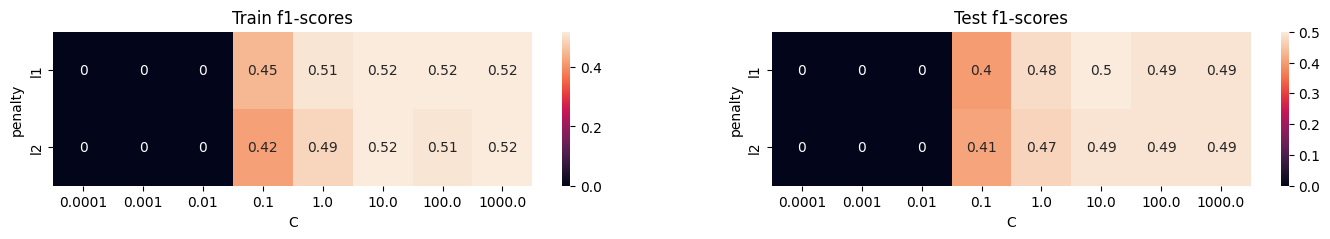

In [32]:
# Переведём данные в числовые
f1_train = f1_train.astype('float')
f1_test = f1_test.astype('float')

# Строим две тепловые карты со значениями метрики
fig, axes = plt.subplots(1, 2, figsize=(17, 2))
sns.heatmap(f1_train, annot=True, ax=axes[0])
axes[0].set_title('Train f1-scores')
axes[0].set_xlabel('C')
axes[0].set_ylabel('penalty')
sns.heatmap(f1_test, annot=True, ax=axes[1])
axes[1].set_title('Test f1-scores')
axes[1].set_xlabel('C')
axes[1].set_ylabel('penalty');

Итак, если исходить из условий задания, модель можно считать переобученной. Хотя и метрика на тренировочной и тестовой выборках отличаются слабо.

При изменении типа регуляризации и C, обратного коэффициенту регуляризации, можно заметить, что значения метрик для обеих выборок остаются довольно схожими.

Также можно заметить, что значения метрики при C>0.1 практически идентичны значениям с параметрами по умолчанию.

> Ваши выводы и рассуждения — *здесь*.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [33]:
# Ваш код здесь
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
# Создаём полиномиальные признаки для двух выборок
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
# Создадим и обучим модель на полиномиальных призканах
log_reg_poly = linear_model.LogisticRegression(random_state=42, max_iter=1000)
log_reg_poly.fit(X_train_poly, y_train)
# Предсказание на тренировочной выборке
y_pred_train_poly = log_reg_poly.predict(X_train_poly)
# Предсказание на тестовой выборке
y_pred_test_poly = log_reg_poly.predict(X_test_poly)
# Выведем значения метрики
print(f'F1 score train: {(metrics.f1_score(y_train, y_pred_train_poly)):.2f}')
print(f'F1 score test: {(metrics.f1_score(y_test, y_pred_test_poly)):.2f}')

F1 score train: 0.66
F1 score test: 0.64


In [34]:
# Создадим две таблицы со значениями С и типом регуляризации, и посчитаем метрики для каждой комбинации значений
f1_train_poly = pd.DataFrame(index=penalties, columns=Cs)
f1_test_poly = pd.DataFrame(index=penalties, columns=Cs)
for i, penalty in enumerate(penalties):
    for j, C in enumerate(Cs):
        # solver по умолчанию не поддерживает l1-регуляризацию
        # Ругается, что max_iter, но иначе слишком долго считает, а значения по итогу не отличаются
        log_reg_temp = linear_model.LogisticRegression(random_state=42, max_iter=1000, solver='saga', penalty=penalty, C=C)
        log_reg_temp.fit(X_train_poly, y_train)
        # Делаем предсказание на тренировочной выборке и считаем метрику, результат заносим в таблицу
        y_pred_train_temp = log_reg_temp.predict(X_train_poly)
        f1_train_poly.iloc[i,j] = round(metrics.f1_score(y_train, y_pred_train_temp), 2)
        # Аналогично для тестовой выборки
        y_pred_test_temp = log_reg_temp.predict(X_test_poly)
        f1_test_poly.iloc[i,j] = round(metrics.f1_score(y_test, y_pred_test_temp), 2)

C:\Users\molde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\molde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\molde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\molde\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:350: Conve

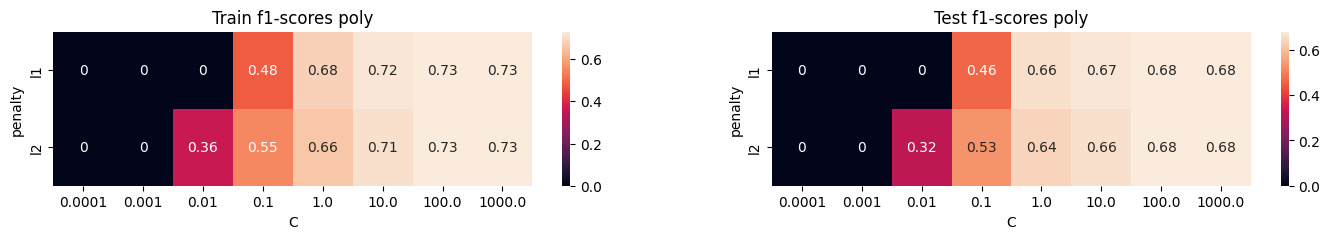

In [35]:
# Переведём данные в числовые
f1_train_poly = f1_train_poly.astype('float')
f1_test_poly = f1_test_poly.astype('float')

# Строим две тепловые карты со значениями метрики
fig, axes = plt.subplots(1, 2, figsize=(17, 2))
sns.heatmap(f1_train_poly, annot=True, ax=axes[0])
axes[0].set_title('Train f1-scores poly')
axes[0].set_xlabel('C')
axes[0].set_ylabel('penalty')
sns.heatmap(f1_test_poly, annot=True, ax=axes[1])
axes[1].set_title('Test f1-scores poly')
axes[1].set_xlabel('C')
axes[1].set_ylabel('penalty');

Качество модели значительно улучшилось. Значения $F_1$-меры отличаются не критически на разных выборках.

С параметрами по умолчанию значение метрики на тренировочной выборке несколько лучше, чем на тестовой, но при приминении регуляризации значения становятся одинаковы (что наверное логично, т.к. регуляризация должна бороться с переобучением и значения метрик на выборках должны стать ближе друг к другу), но при этом хуже, чем без неё, что говорит о том, что в этом случае скорее всего регуляризация не требуется.

> Ваши выводы и рассуждения — *здесь*

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

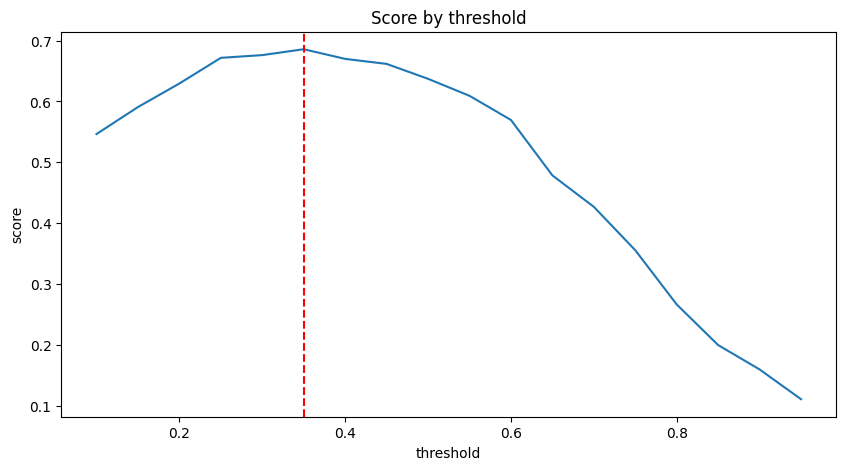

In [36]:
# Ваш код здесь
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_pred_poly)
    # Добавляем результат в список
    scores.append(score)

fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(
    x=thresholds,
    y=scores,
    ax=ax
)
ax.set_xlabel('threshold')
ax.set_ylabel('score')
ax.set_title('Score by threshold')

# Оптимальный порог вероятности
threshold = thresholds[scores.index(max(scores))]
plt.axvline(threshold, c='red', ls='--');

In [49]:
y_train_proba_pred = pd.Series(log_reg_poly.predict_proba(X_train_poly)[:, 1])
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_poly)[:, 1])
# Делаем предсказание для двух выборок
y_train_pred_poly = y_train_proba_pred.apply(lambda x: 1 if x > threshold else 0)
y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
# Считаем метрику для двух выборок
print(f'F1 score train: {(metrics.f1_score(y_train, y_train_pred_poly)):.2f}')
print(f'F1 score test: {(metrics.f1_score(y_test, y_test_pred_poly)):.2f}')

F1 score train: 0.69
F1 score test: 0.69


: 

Оптимальным порогом вероятности оказалось значение 0.3.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [38]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [39]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [40]:
# Ваш код здесь
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
# Обучаем модель
dt_clf.fit(X_train, y_train)
# Делаем предсказания
y_pred_train = dt_clf.predict(X_train)
y_pred_test = dt_clf.predict(X_test)
# Считаем F1-меру
print(f'F1 score train: {(metrics.f1_score(y_train, y_pred_train)):.2f}')
print(f'F1 score test: {(metrics.f1_score(y_test, y_pred_test)):.2f}')

F1 score train: 1.00
F1 score test: 0.57


Модель получилась явно переобученной. Она идеально подстроилась под тренировочную выборку, но на тестовой показывает себя значительно хуже. Очевидно это связано с тем, что мы не ограничили глубину и не указали минимальное количество объектов на листе.

> Ваши выводы и рассуждения — *здесь*

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [41]:
# Ваш код здесь
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
# Обучаем модель
dt_clf.fit(X_train, y_train)
# Делаем предсказания
y_pred_train = dt_clf.predict(X_train)
y_pred_test = dt_clf.predict(X_test)
# Считаем F1-меру
print(f'F1 score train: {(metrics.f1_score(y_train, y_pred_train)):.2f}')
print(f'F1 score test: {(metrics.f1_score(y_test, y_pred_test)):.2f}')

F1 score train: 0.72
F1 score test: 0.64


Модель стала лучше. Она уже не так идеально предсказывает класс на трейне, но зато значительно лучше показывает себя на тесте. Теперь значения метрик не различаются столь кардинально.

> Ваши выводы и рассуждения — *здесь*

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [42]:
# Ваш код здесь
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion='entropy',
    max_depth=8,
    min_samples_leaf=10,
    random_state=42
)
# Обучаем модель 
rf_clf.fit(X_train, y_train)
# Делаем предсказания
y_pred_train_f = rf_clf.predict(X_train)
y_pred_test_f = rf_clf.predict(X_test)
# Выводим значения метрики
print(f'F1 score train: {(metrics.f1_score(y_train, y_pred_train_f)):.2f}')
print(f'F1 score test: {(metrics.f1_score(y_test, y_pred_test_f)):.2f}')

F1 score train: 0.74
F1 score test: 0.66


Модель улучшилась, но не слишком сильно. 

F1-мера выросла всего на 0.2 для обеих выборок относительно одного дерева.

> Ваши выводы и рассуждения — *здесь*

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

In [43]:
# Ваш код здесь
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(rf_clf.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_temp = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_pred_temp)
    # Добавляем результат в список
    scores.append(score)

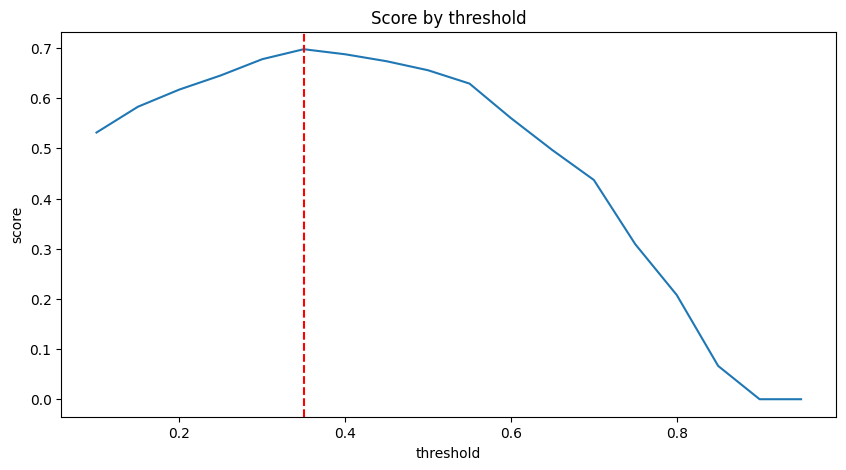

In [44]:
# Строим график зависимости целевой метрики от порога вероятности
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(
    x=thresholds,
    y=scores,
    ax=ax
)
ax.set_xlabel('threshold')
ax.set_ylabel('score')
ax.set_title('Score by threshold')

# Оптимальный порог вероятности
threshold = thresholds[scores.index(max(scores))]
plt.axvline(threshold, c='red', ls='--');

In [45]:
y_train_proba_pred_f = pd.Series(rf_clf.predict_proba(X_train)[:, 1])
y_test_proba_pred_f = pd.Series(rf_clf.predict_proba(X_test)[:, 1])
# Делаем предсказание для двух выборок
y_train_pred_f = y_train_proba_pred_f.apply(lambda x: 1 if x > threshold else 0)
y_test_pred_f = y_test_proba_pred_f.apply(lambda x: 1 if x > threshold else 0)
# Считаем метрику для двух выборок
print(f'F1 score train: {(metrics.f1_score(y_train, y_train_pred_f)):.2f}')
print(f'F1 score test: {(metrics.f1_score(y_test, y_test_pred_f)):.2f}')

F1 score train: 0.77
F1 score test: 0.70


С подобранным порогом вероятности случайный лес показал лучшие значения, даже по сравнению с моделью, обученной на полиномиальных признаках. Она чуть хуже показала себя на трейне, но главное, на тестовой выборке прирост составил 0.4. Если учесть критерий в 0.6-07 для реальных задач, указанный в примечании, можно сказать, что модель показывает себя успешно.

> Ваши выводы и рассуждения — *здесь*

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [46]:
# Ваш код здесь
# Создаём датафрейм из словаря
vasiliy = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
    })
vasiliy

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,601.0,Male,42.0,1.0,98495.72,1.0,1.0,0.0,40014.76


In [47]:
# Создаём новые признаки и преобразуем категориальные
vasiliy['BalanceSalaryRatio'] = vasiliy['Balance'] / vasiliy['EstimatedSalary']
vasiliy['TenureByAge'] = vasiliy['Tenure'] / vasiliy['Age']
vasiliy['CreditScoreGivenAge'] = vasiliy['CreditScore'] / vasiliy['Age']
vasiliy['Gender'] = vasiliy['Gender'].apply(lambda x: 1 if x=='Male' else 0)
vasiliy.shape

(1, 12)

In [48]:
# Предсказываем вероятность того, что Василий откажется от услуг банка
print(f'Vasiliy probability of exiting {(rf_clf.predict_proba(vasiliy)[:, 1][0] * 100):.2f}%')

Vasiliy probability of exiting 61.43%


Приведя данные Василия в соответствие с обучающей выборкой, выбираем модель, показавшую лучшие результаты - случайный лес. Получаем вероятность, что Василий откажется от услуг банка чуть выше 61%. Таким образом он будет помечен, как класс 1 даже с порогом вероятности по умолчанию.